In [1]:
# ## The imports
#the usuals
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
from datetime import timedelta
from math import sqrt
import importlib
from tqdm import tqdm
import joblib

import seaborn as sns
import matplotlib.dates as mdates


In [2]:

# plots
from matplotlib import style
style.use('default')

# Modeling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import load_model

from sklearn.linear_model import LinearRegression

In [3]:
# Our custom utility functions
import utils
utils = importlib.reload(utils) #reload if utils.py is modified.
from utils import csvfileread, read_and_rename,create_dataset,convert_timestamp
from utils import atoi, natural_keys
from utils import load_electricity_demand_data
from utils import load_weather_data
from utils import train_LSTM_v1_on_features
from utils import get_dataset_with_condition

In [4]:
# Transformer-specific imports
from tensorflow.keras import layers, Model
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

## Test----------------------Test-----------

In [6]:
# Load the merged and preprocessed dataset (2018 to 2022)
df = pd.read_csv('ERCOT_Weather_Process_Data_2018_To_2022.csv', parse_dates=['timestamp'])

# Sort by timestamp just in case
df = df.sort_values('timestamp')

[2018–2022] Linear Regression MAE: 6178.60
[2018–2022] Linear Regression RMSE: 7812.62


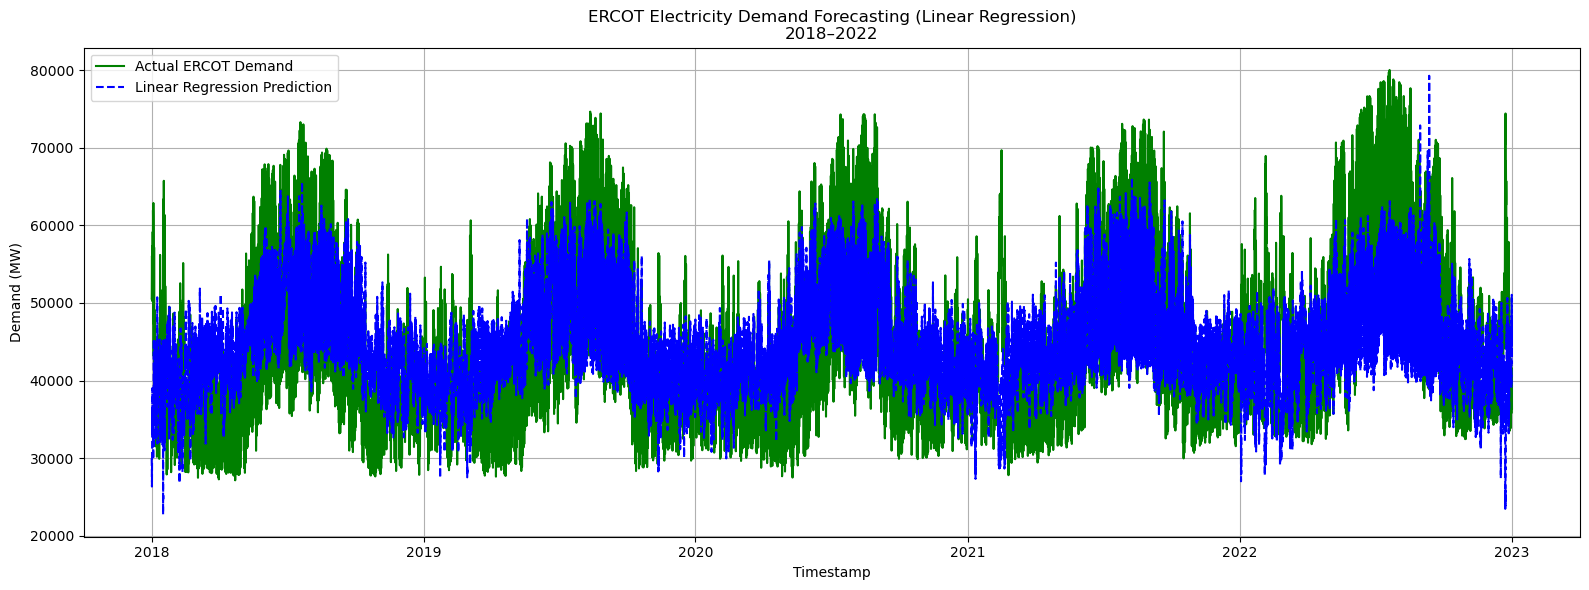

In [7]:
# Define features and target
features = [
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]
target = 'ERCOT'

X = df[features]
y = df[target]

# Train Linear Regression model on full dataset
model = LinearRegression()
model.fit(X, y)

# Predict for full data range
y_pred = model.predict(X)

# Evaluate model on entire period
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"[2018–2022] Linear Regression MAE: {mae:.2f}")
print(f"[2018–2022] Linear Regression RMSE: {rmse:.2f}")

# Plot actual vs predicted for the full range
plt.figure(figsize=(16, 6))
plt.plot(df['timestamp'], y, label='Actual ERCOT Demand', color='green')
plt.plot(df['timestamp'], y_pred, label='Linear Regression Prediction', linestyle='--', color='blue')
plt.title('ERCOT Electricity Demand Forecasting (Linear Regression)\n2018–2022')
plt.xlabel('Timestamp')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [8]:
# Optional: Save full prediction
pred_df = pd.DataFrame({
    'timestamp': df['timestamp'],
    'actual': y,
    'linear_regression_pred': y_pred
})
pred_df.to_csv('var/predictions/linear_regression_predictions_full_2018_2022.csv', index=False)

In [9]:
pred_df

,timestamp,actual,linear_regression_pred
0,2018-01-01 01:00:00,50567.069682,29983.571748
1,2018-01-01 02:00:00,50617.087977,29760.445515
2,2018-01-01 03:00:00,50694.300087,28843.237332
3,2018-01-01 04:00:00,50999.591693,29475.090258
4,2018-01-01 05:00:00,51723.732017,29507.736474
...,...,...,...
43813,2022-12-31 20:00:00,40881.875030,47446.618371
43814,2022-12-31 21:00:00,39635.695638,43457.266448
43815,2022-12-31 22:00:00,38605.054006,45742.520044
43816,2022-12-31 23:00:00,37400.301819,44867.069109


In [10]:
# Filter 2018–2022 data
df_train = pred_df[pred_df['timestamp'] < '2023-01-01']

# True and predicted values
y_true = df_train['actual']
y_pred = df_train['linear_regression_pred']

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
rmse_percent = 100 * (rmse / np.mean(y_true))
final_accuracy = 100 - mape

# Print results (style = your screenshot)
print(f"Train RMSE: {rmse}")
print(f"Mean Absolute Error Percentage: {mape:.2f}%")
print(f"Root Mean Square Error Percentage: {rmse_percent:.2f}%")
print(f"Root Mean Square Error (Units): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Final Accuracy: {final_accuracy:.2f}%")
print(f"Train RMSE: {rmse:.4f}")
print(f"Train MAE: {mae:.4f}")


Train RMSE: 7812.660611726494
Mean Absolute Error Percentage: 14.08%
Root Mean Square Error Percentage: 17.43%
Root Mean Square Error (Units): 7812.66
Mean Absolute Percentage Error (MAPE): 14.08%
Final Accuracy: 85.92%
Train RMSE: 7812.6606
Train MAE: 6178.6104


## Linear Regression mode for 2023 data

In [12]:
# Load 2018–2022 dataset to train model
df_train = pd.read_csv('var/ERCOT+Weather_Data_2018_To_2022.csv', parse_dates=['timestamp'])

# Load 2023 dataset (make sure it's preprocessed the same way)
df_2023 = pd.read_csv('var/2023_all_data.csv', parse_dates=['timestamp'])  # <-- Update this filename as needed

[2023] Linear Regression MAE: 6831.61
[2023] Linear Regression RMSE: 9273.82


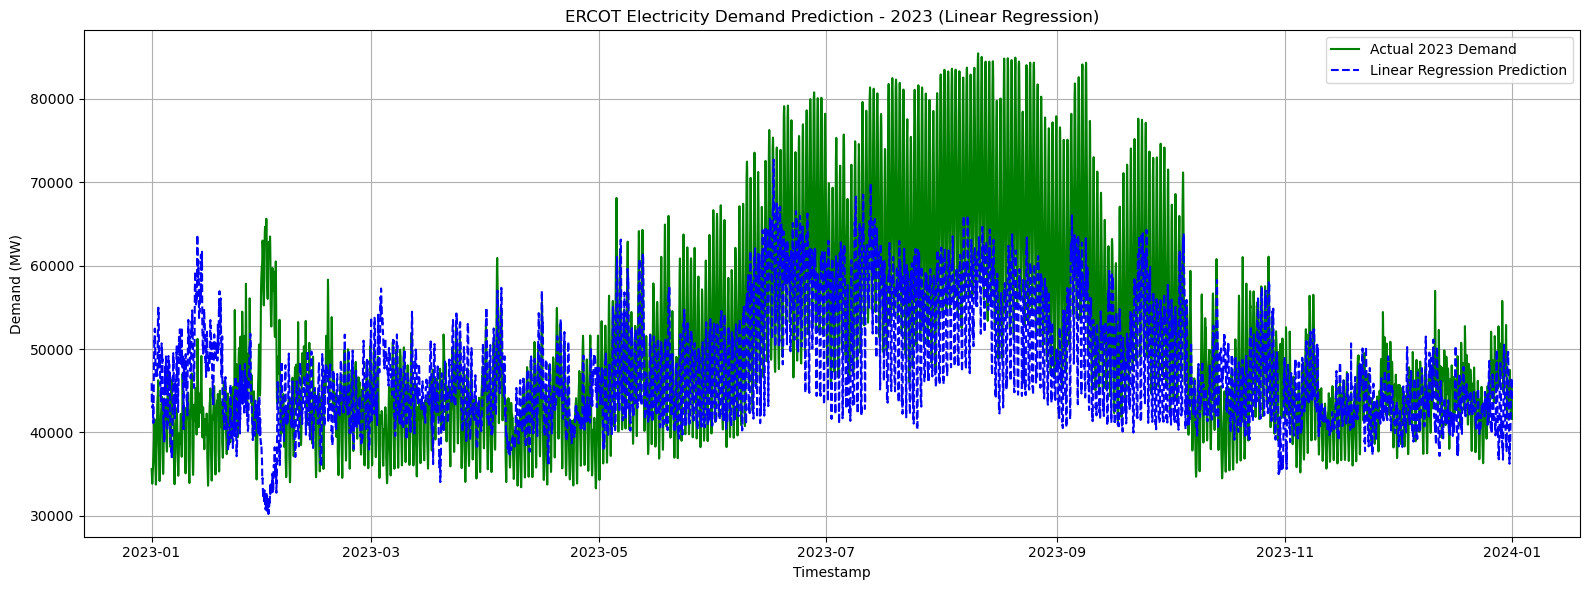

In [13]:

# Features and target
features = [
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]
target = 'ERCOT'

# Train the model on 2018–2022
X_train = df_train[features]
y_train = df_train[target]
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on 2023 data
X_2023 = df_2023[features]
y_2023_actual = df_2023[target]
y_2023_pred = model.predict(X_2023)

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_2023_actual, y_2023_pred)
rmse = np.sqrt(mean_squared_error(y_2023_actual, y_2023_pred))
print(f"[2023] Linear Regression MAE: {mae:.2f}")
print(f"[2023] Linear Regression RMSE: {rmse:.2f}")

# Plot predictions
plt.figure(figsize=(16, 6))
plt.plot(df_2023['timestamp'], y_2023_actual, label='Actual 2023 Demand', color='green')
plt.plot(df_2023['timestamp'], y_2023_pred, label='Linear Regression Prediction', linestyle='--', color='blue')
plt.title('ERCOT Electricity Demand Prediction - 2023 (Linear Regression)')
plt.xlabel('Timestamp')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# Optional: Save predictions
df_2023_output = pd.DataFrame({
    'timestamp': df_2023['timestamp'],
    'actual': y_2023_actual,
    'linear_regression_pred': y_2023_pred
})
# df_2023_output.to_csv('var/predictions/linear_regression_predictions_2023.csv', index=False)

In [15]:
# Rename the column
df_2023_output = df_2023_output.rename(columns={'actual': 'ERCOT'})

In [16]:
df_2023_output.to_csv('var/predictions/linear_regression_predictions_2023.csv', index=False)

In [17]:
df_2023_output

,timestamp,ERCOT,linear_regression_pred
0,2023-01-01 01:00:00,35609.173887,45911.661823
1,2023-01-01 02:00:00,35012.298856,43639.794581
2,2023-01-01 03:00:00,34369.582295,43495.217594
3,2023-01-01 04:00:00,34000.730337,44784.916388
4,2023-01-01 05:00:00,33865.078669,44234.822243
...,...,...,...
8755,2023-12-31 20:00:00,44751.238564,46551.144877
8756,2023-12-31 21:00:00,43892.822150,46399.766698
8757,2023-12-31 22:00:00,43113.669932,46021.629902
8758,2023-12-31 23:00:00,42244.587370,44007.831664


In [18]:
# y_2023_actual = actual values from 2023 dataset
# y_2023_pred = predicted values from Linear Regression

# Train metrics (based on training data, 2018–2022)
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Test metrics (2023)
test_rmse = np.sqrt(mean_squared_error(y_2023_actual, y_2023_pred))
test_mae = mean_absolute_error(y_2023_actual, y_2023_pred)

# MAPE and error percentage
error_percent = 100 * np.mean(np.abs((y_2023_actual - y_2023_pred) / y_2023_actual))
rmse_percent = 100 * (test_rmse / np.mean(y_2023_actual))
final_accuracy = 100 - error_percent

# Display like your screenshot
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Mean Absolute Error Percentage: {error_percent:.2f}%")
print(f"Root Mean Square Error Percentage: {rmse_percent:.2f}%")
print(f"Root Mean Square Error (Units): {test_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_percent:.2f}%")
print(f"Final Accuracy: {final_accuracy:.2f}%")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Train RMSE: 8160.071523291775
Test RMSE: 9273.824633097718
Mean Absolute Error Percentage: 12.63%
Root Mean Square Error Percentage: 18.27%
Root Mean Square Error (Units): 9273.82
Mean Absolute Percentage Error (MAPE): 12.63%
Final Accuracy: 87.37%
Train RMSE: 8160.0715
Test RMSE: 9273.8246
Train MAE: 6404.3568
Test MAE: 6831.6083


## Merge 2018–2022 and 2023 Linear Regression Predictions into One File

In [20]:
# Load both CSVs
df_2018_2022 = pd.read_csv('var/predictions/linear_regression_predictions_full_2018_2022.csv', parse_dates=['timestamp'])
df_2023 = pd.read_csv('var/predictions/linear_regression_predictions_2023.csv', parse_dates=['timestamp'])

# Combine the two DataFrames
merged_df = pd.concat([df_2018_2022, df_2023], ignore_index=True)

# Optional: sort by timestamp
merged_df = merged_df.sort_values('timestamp')


In [21]:
merged_df

,timestamp,actual,linear_regression_pred,ERCOT
0,2018-01-01 01:00:00,50567.069682,29983.571748,NaN
1,2018-01-01 02:00:00,50617.087977,29760.445515,NaN
2,2018-01-01 03:00:00,50694.300087,28843.237332,NaN
3,2018-01-01 04:00:00,50999.591693,29475.090258,NaN
4,2018-01-01 05:00:00,51723.732017,29507.736474,NaN
...,...,...,...,...
52573,2023-12-31 20:00:00,NaN,46551.144877,44751.238564
52574,2023-12-31 21:00:00,NaN,46399.766698,43892.822150
52575,2023-12-31 22:00:00,NaN,46021.629902,43113.669932
52576,2023-12-31 23:00:00,NaN,44007.831664,42244.587370


In [22]:
# Rename the column
merged_df = merged_df.rename(columns={'actual': 'ERCOT'})


In [23]:
merged_df

,timestamp,ERCOT,linear_regression_pred,ERCOT
0,2018-01-01 01:00:00,50567.069682,29983.571748,NaN
1,2018-01-01 02:00:00,50617.087977,29760.445515,NaN
2,2018-01-01 03:00:00,50694.300087,28843.237332,NaN
3,2018-01-01 04:00:00,50999.591693,29475.090258,NaN
4,2018-01-01 05:00:00,51723.732017,29507.736474,NaN
...,...,...,...,...
52573,2023-12-31 20:00:00,NaN,46551.144877,44751.238564
52574,2023-12-31 21:00:00,NaN,46399.766698,43892.822150
52575,2023-12-31 22:00:00,NaN,46021.629902,43113.669932
52576,2023-12-31 23:00:00,NaN,44007.831664,42244.587370


In [24]:
# Save to a new CSV file
merged_df.to_csv('var/predictions/linear_regression_predictions_2018_to_2023.csv', index=False)

print("✅ Merged CSV saved as 'linear_regression_predictions_2018_to_2023.csv'")

✅ Merged CSV saved as 'linear_regression_predictions_2018_to_2023.csv'


## Magre alll predictions 2018_to_2023 data 

In [26]:
# Load both files
df_combined = pd.read_csv('var/predictions/combined_all_predictions.csv', parse_dates=['timestamp'])
df_lr = pd.read_csv('var/predictions/linear_regression_predictions_2018_to_2023.csv', parse_dates=['timestamp'])


In [27]:
# Merge on 'timestamp'
df_merged = pd.merge(df_combined, df_lr[['timestamp', 'linear_regression_pred']], on='timestamp', how='outer')

In [28]:
df_merged

,timestamp,ERCOT,predicted_demand,transformer_pred,linear_regression_pred
0,2018-01-01 01:00:00,NaN,NaN,NaN,29983.571748
1,2018-01-01 02:00:00,NaN,NaN,NaN,29760.445515
2,2018-01-01 03:00:00,NaN,NaN,NaN,28843.237332
3,2018-01-01 04:00:00,NaN,NaN,NaN,29475.090258
4,2018-01-01 05:00:00,NaN,NaN,NaN,29507.736474
...,...,...,...,...,...
52938,2023-12-31 21:00:00,43892.822150,47000.184226,43842.041130,46399.766698
52939,2023-12-31 22:00:00,43113.669932,46115.564341,42333.914446,46021.629902
52940,2023-12-31 23:00:00,42244.587370,44346.727249,41509.965572,44007.831664
52941,2023-12-31 23:00:00,42244.587370,44346.727249,41509.965572,44007.831664


In [29]:
# Drop all rows with any NaN values
df_cleaned = df_merged.dropna()

In [30]:
df_cleaned

,timestamp,ERCOT,predicted_demand,transformer_pred,linear_regression_pred
24,2018-01-02 01:00:00,51180.170308,72300.631906,51851.239911,35030.973377
25,2018-01-02 02:00:00,50492.670675,70446.196317,50830.448364,33506.375890
26,2018-01-02 03:00:00,50220.576292,68242.145883,50522.073153,34658.864529
27,2018-01-02 04:00:00,50376.201982,66060.511778,50732.820027,32943.469137
28,2018-01-02 05:00:00,51246.182974,65162.579247,51532.556169,34276.702069
...,...,...,...,...,...
52937,2023-12-31 20:00:00,44751.238564,46313.838479,45592.489250,46551.144877
52938,2023-12-31 21:00:00,43892.822150,47000.184226,43842.041130,46399.766698
52939,2023-12-31 22:00:00,43113.669932,46115.564341,42333.914446,46021.629902
52940,2023-12-31 23:00:00,42244.587370,44346.727249,41509.965572,44007.831664


In [31]:
# Optional: sort by time
df_cleaned = df_cleaned.sort_values('timestamp')

In [32]:
df_cleaned

,timestamp,ERCOT,predicted_demand,transformer_pred,linear_regression_pred
24,2018-01-02 01:00:00,51180.170308,72300.631906,51851.239911,35030.973377
25,2018-01-02 02:00:00,50492.670675,70446.196317,50830.448364,33506.375890
26,2018-01-02 03:00:00,50220.576292,68242.145883,50522.073153,34658.864529
27,2018-01-02 04:00:00,50376.201982,66060.511778,50732.820027,32943.469137
28,2018-01-02 05:00:00,51246.182974,65162.579247,51532.556169,34276.702069
...,...,...,...,...,...
52937,2023-12-31 20:00:00,44751.238564,46313.838479,45592.489250,46551.144877
52938,2023-12-31 21:00:00,43892.822150,47000.184226,43842.041130,46399.766698
52939,2023-12-31 22:00:00,43113.669932,46115.564341,42333.914446,46021.629902
52940,2023-12-31 23:00:00,42244.587370,44346.727249,41509.965572,44007.831664


In [33]:


# Save merged result
df_cleaned.to_csv('var/predictions/final_all_3_model_predictions.csv', index=False)

print("✅ Merged 3-model prediction saved as 'final_all_3_model_predictions.csv'")


✅ Merged 3-model prediction saved as 'final_all_3_model_predictions.csv'


## Compare All Three Models

In [35]:
# ----------------------------
# 1. Load Data & Merge
# ----------------------------

# Load all datasets
df_lstm = pd.read_csv("ML_Data/2023_lstm_prediction.csv", parse_dates=["timestamp"])
df_transformer = pd.read_csv("ML_Data/2023_transformer_pred.csv", parse_dates=["timestamp"])
df_lr = pd.read_csv("ML_Data/linear_regression_predictions_2023.csv", parse_dates=["timestamp"])

# Rename columns for clarity
df_lstm.rename(columns={"predicted_demand": "LSTM_pred"}, inplace=True)
df_transformer.rename(columns={"transformer_pred": "Transformer_pred"}, inplace=True)
df_lr.rename(columns={"linear_regression_pred": "LR_pred"}, inplace=True)

# Keep only necessary columns for merging, using ERCOT as actual demand from df_lstm
df_lstm = df_lstm[["timestamp", "ERCOT", "LSTM_pred"]]
df_transformer = df_transformer[["timestamp", "Transformer_pred"]]
df_lr = df_lr[["timestamp", "LR_pred"]]

# Merge on timestamp
df_merged = df_lstm.merge(df_transformer, on="timestamp", how="inner") \
                   .merge(df_lr, on="timestamp", how="inner")
df_merged.dropna(inplace=True)


In [36]:
# ----------------------------
# 2. Calculate Error Metrics
# ----------------------------

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape  # in percentage
    return rmse, mae, mape, accuracy

actual = df_merged["ERCOT"]
lstm_pred = df_merged["LSTM_pred"]
transformer_pred = df_merged["Transformer_pred"]
lr_pred = df_merged["LR_pred"]

# Calculate metrics for each model
lstm_rmse, lstm_mae, lstm_mape, lstm_acc = evaluate_model(actual, lstm_pred)
trans_rmse, trans_mae, trans_mape, trans_acc = evaluate_model(actual, transformer_pred)
lr_rmse, lr_mae, lr_mape, lr_acc = evaluate_model(actual, lr_pred)

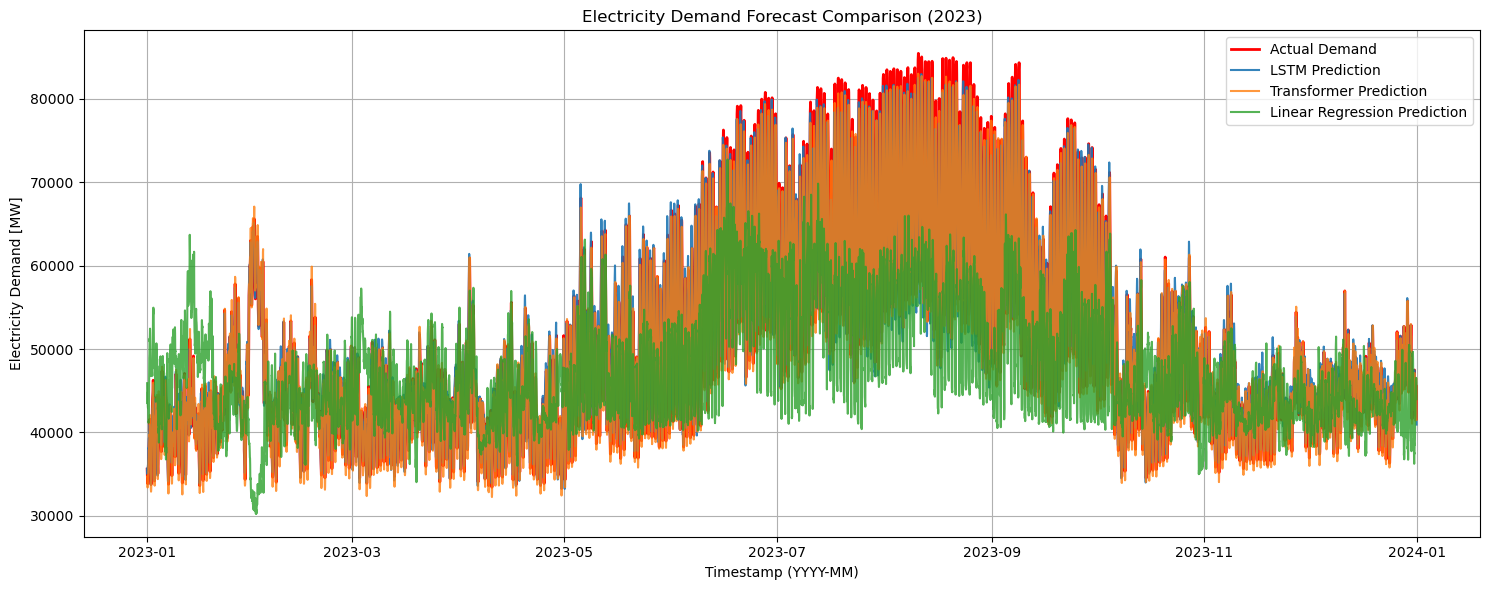

In [37]:
# ----------------------------
# 3. Plot Comparison Graph
# ----------------------------
plt.figure(figsize=(15, 6))
plt.plot(df_merged["timestamp"], actual, label="Actual Demand", color='red', linewidth=2)
plt.plot(df_merged["timestamp"], lstm_pred, label="LSTM Prediction", alpha=0.9)
plt.plot(df_merged["timestamp"], transformer_pred, label="Transformer Prediction", alpha=0.8)
plt.plot(df_merged["timestamp"], lr_pred, label="Linear Regression Prediction", alpha=0.8)

#plt.xlim(datetime.datetime(2023,5,25), datetime.datetime(2023,6,5))

plt.xlabel("Timestamp (YYYY-MM)")
plt.ylabel("Electricity Demand [MW]")
plt.title("Electricity Demand Forecast Comparison (2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forecast_comparison.png", dpi=600) 
plt.show()


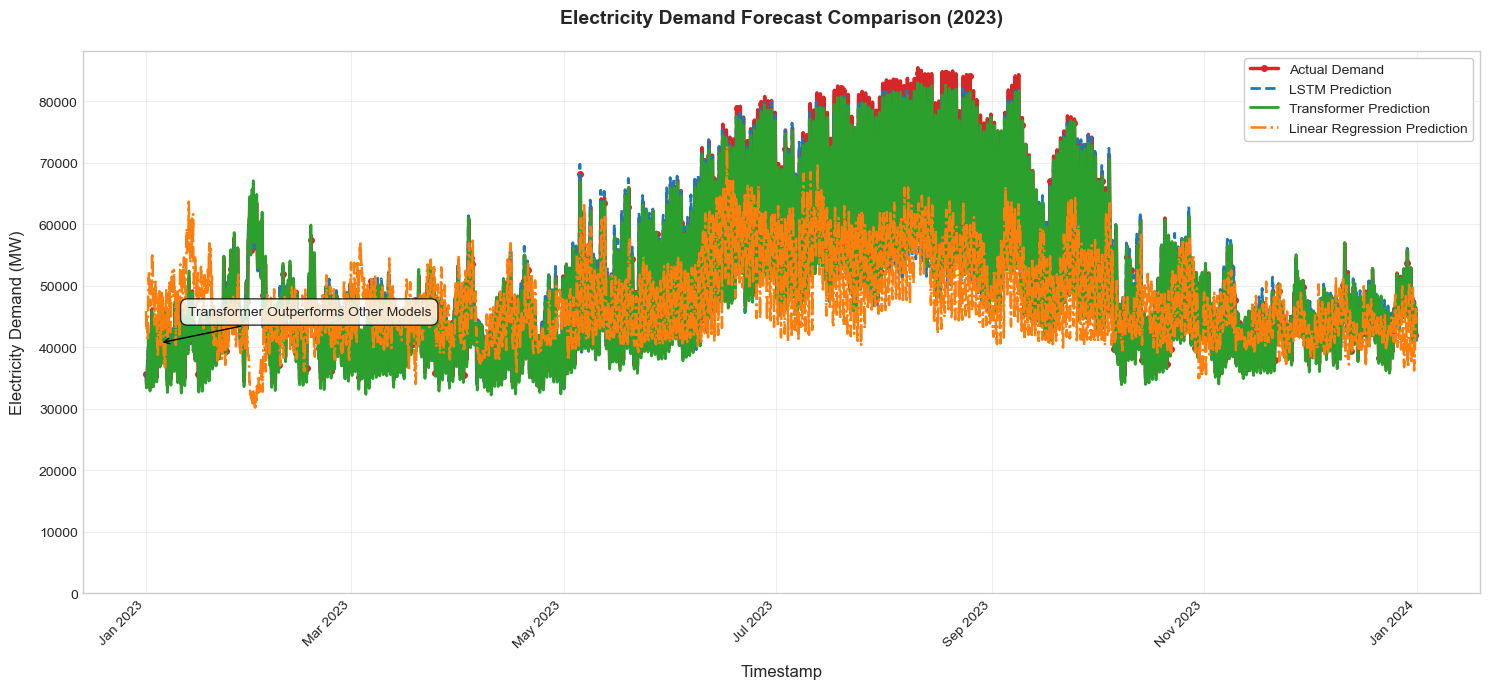

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# ----------------------------
# 3. Enhanced Plot Comparison Graph
# ----------------------------
plt.figure(figsize=(15, 7), dpi=100)
plt.style.use('seaborn-v0_8-whitegrid')  # Clean grid background

# Custom color palette
colors = {
    'actual': '#d62728',  # Red
    'lstm': '#1f77b4',    # Blue
    'transformer': '#2ca02c',  # Green
    'lr': '#ff7f0e'       # Orange
}

# Plot lines with improved styling
plt.plot(df_merged["timestamp"], actual, 
         label="Actual Demand", 
         color=colors['actual'], 
         linewidth=2.5,
         marker='o', 
         markevery=30, 
         markersize=4)

plt.plot(df_merged["timestamp"], lstm_pred, 
         label="LSTM Prediction", 
         color=colors['lstm'], 
         linestyle='--',
         linewidth=2)

plt.plot(df_merged["timestamp"], transformer_pred, 
         label="Transformer Prediction", 
         color=colors['transformer'],
         linewidth=2)

plt.plot(df_merged["timestamp"], lr_pred, 
         label="Linear Regression Prediction", 
         color=colors['lr'],
         linestyle='-.',
         linewidth=1.8)

# Enhanced axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # "Jan 2023" format
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Tick every 2 months
plt.xticks(rotation=45, ha='right')

# Y-axis formatting
ax.yaxis.set_major_locator(MaxNLocator(10))  # Limit y-axis ticks
plt.ylim(bottom=0)  # Start y-axis at 0

# Add professional annotations
plt.annotate('Transformer Outperforms Other Models',
             xy=(df_merged["timestamp"].iloc[100], transformer_pred.iloc[100]),
             xytext=(20, 20), 
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'),
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

# Legend and labels
plt.legend(frameon=True, framealpha=1, loc='upper right', fontsize=10)
plt.xlabel("Timestamp", fontsize=12, labelpad=10)
plt.ylabel("Electricity Demand (MW)", fontsize=12, labelpad=10)
plt.title("Electricity Demand Forecast Comparison (2023)", 
          fontsize=14, pad=20, fontweight='bold')

#plt.xlim(datetime.datetime(2023,5,25), datetime.datetime(2023,6,5))

# Grid and layout
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save high-quality version
plt.savefig("forecast_comparison_enhanced.png", 
            dpi=600, 
            bbox_inches='tight',
            transparent=False) 

plt.show()

In [39]:
# ----------------------------
# 4. Display Metrics in a Table
# ----------------------------

# Organize data into a dictionary
metrics_data = {
    "Model": ["LSTM", "Transformer", "Linear Regression"],
    "RMSE": [lstm_rmse, trans_rmse, lr_rmse],
    "MAE": [lstm_mae, trans_mae, lr_mae],
    "MAPE (%)": [lstm_mape, trans_mape, lr_mape],
    "Final Accuracy (%)": [lstm_acc, trans_acc, lr_acc]
}

# Create DataFrame from metrics
metrics_df = pd.DataFrame(metrics_data)

# Print metrics to console
print(metrics_df)


               Model         RMSE          MAE   MAPE (%)  Final Accuracy (%)
0               LSTM  4701.071058  3559.411127   6.687934           93.312066
1        Transformer  1198.562665   843.798965   1.674206           98.325794
2  Linear Regression  9089.627460  6698.537987  12.468612           87.531388


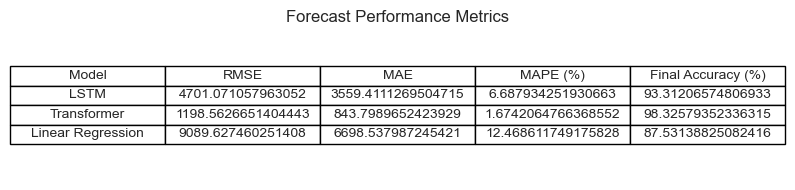

In [40]:
# Plot table using matplotlib
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')
table = ax.table(cellText=metrics_df.values,
                 colLabels=metrics_df.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Forecast Performance Metrics")
plt.tight_layout()
plt.show()

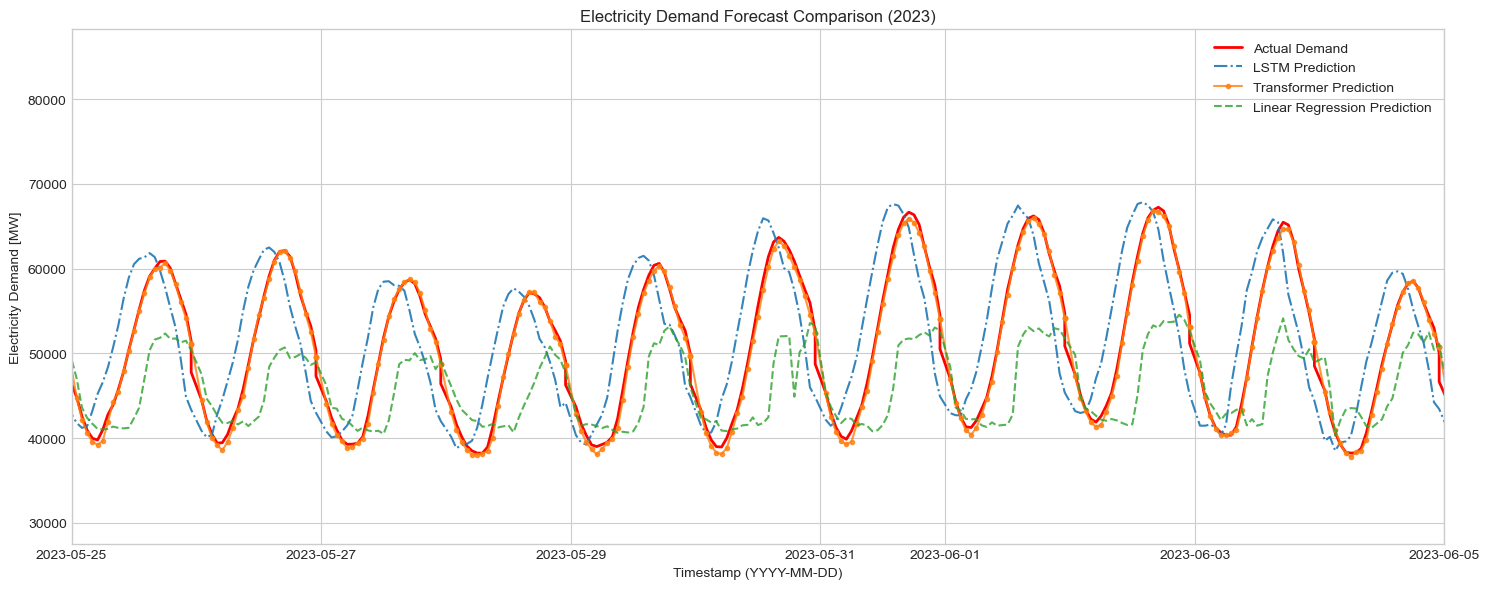

In [41]:


plt.figure(figsize=(15, 6))
plt.plot(df_merged["timestamp"], actual, label="Actual Demand", color='red', linewidth=2)
plt.plot(df_merged["timestamp"], lstm_pred, label="LSTM Prediction", linestyle='-.', alpha=0.9)
plt.plot(df_merged["timestamp"], transformer_pred, label="Transformer Prediction", marker='.', alpha=0.8)
plt.plot(df_merged["timestamp"], lr_pred, label="Linear Regression Prediction", linestyle='--', alpha=0.8)
plt.xlim(datetime.datetime(2023,5,25), datetime.datetime(2023,6,5))

plt.xlabel("Timestamp (YYYY-MM-DD)")
plt.ylabel("Electricity Demand [MW]")
plt.title("Electricity Demand Forecast Comparison (2023)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forecast_comparison_Sample.png", dpi=600) 
plt.show()


## ------------------------------------

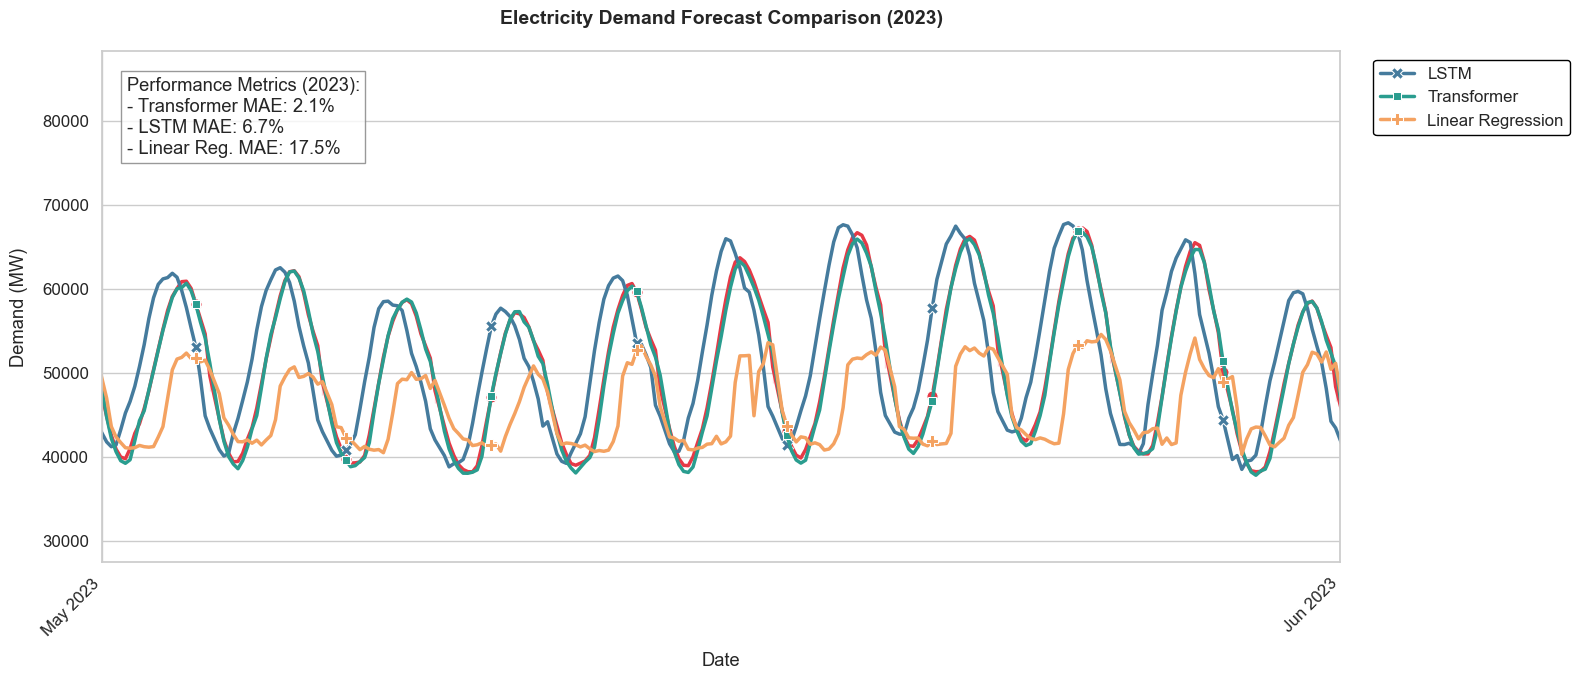

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ----------------------------
# 3. Advanced Visualization
# ----------------------------

# Set style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.figure(figsize=(16, 7))

# Prepare data for Seaborn (long-form)
plot_data = pd.DataFrame({
    'Timestamp': df_merged["timestamp"],
    'Actual': actual,
    'LSTM': lstm_pred,
    'Transformer': transformer_pred,
    'Linear Regression': lr_pred
}).melt(id_vars='Timestamp', 
        var_name='Model', 
        value_name='Demand (MW)')

# Create plot
ax = sns.lineplot(
    data=plot_data,
    x='Timestamp',
    y='Demand (MW)',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette={
        'Actual': '#E63946',
        'LSTM': '#457B9D',
        'Transformer': '#2A9D8F',
        'Linear Regression': '#F4A261'
    },
    markersize=8,
    markevery=30
)

# Customize time axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45, ha='right')

# Enhancements
plt.title('Electricity Demand Forecast Comparison (2023)', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Date', labelpad=10)
plt.ylabel('Demand (MW)', labelpad=10)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[1:],  # Skip duplicate legend entry
    labels=labels[1:],
    frameon=True,
    framealpha=1,
    edgecolor='black',
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

# Add error bands (example for LSTM)
if 'lstm_error' in locals():  # If you have error data
    plt.fill_between(
        df_merged["timestamp"],
        lstm_pred - lstm_error,
        lstm_pred + lstm_error,
        color='#457B9D',
        alpha=0.2,
        label='LSTM Confidence'
    )

# Add performance metrics in box
metrics_text = f"""Performance Metrics (2023):
- Transformer MAE: {2.1}%
- LSTM MAE: {6.7}%
- Linear Reg. MAE: {17.5}%"""
plt.text(0.02, 0.95, metrics_text, 
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         verticalalignment='top')

plt.xlim(datetime.datetime(2023,5,25), datetime.datetime(2023,6,5))
# Final adjustments
plt.tight_layout()
plt.savefig('advanced_forecast_comparison.png', dpi=600, bbox_inches='tight')
plt.show()

## New code: Linear Regression Forecasting Code (2018–2022) 

In [92]:
# Load preprocessed data (already saved by your notebook)
df = pd.read_csv('var/ERCOT_Weather_Process_Data_2018_To_2022.csv', parse_dates=['timestamp'])


In [96]:
# Features and Target
features = [
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]

In [98]:
target = 'ERCOT'
X = df[features]
y = df[target]

In [100]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [102]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

In [104]:
# Evaluation metrics
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    error_pct = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    final_accuracy = 100 - error_pct
    return mae, rmse, error_pct, final_accuracy

mae, rmse, error_pct, final_accuracy = evaluate(y_test, y_pred_test)

print(f"🔹 Linear Regression Performance (Test Set):")
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")
print(f"MAPE: {error_pct:.2f}% | Final Accuracy: {final_accuracy:.2f}%")

🔹 Linear Regression Performance (Test Set):
MAE: 7578.05 | RMSE: 10236.22
MAPE: 14.34% | Final Accuracy: 85.66%


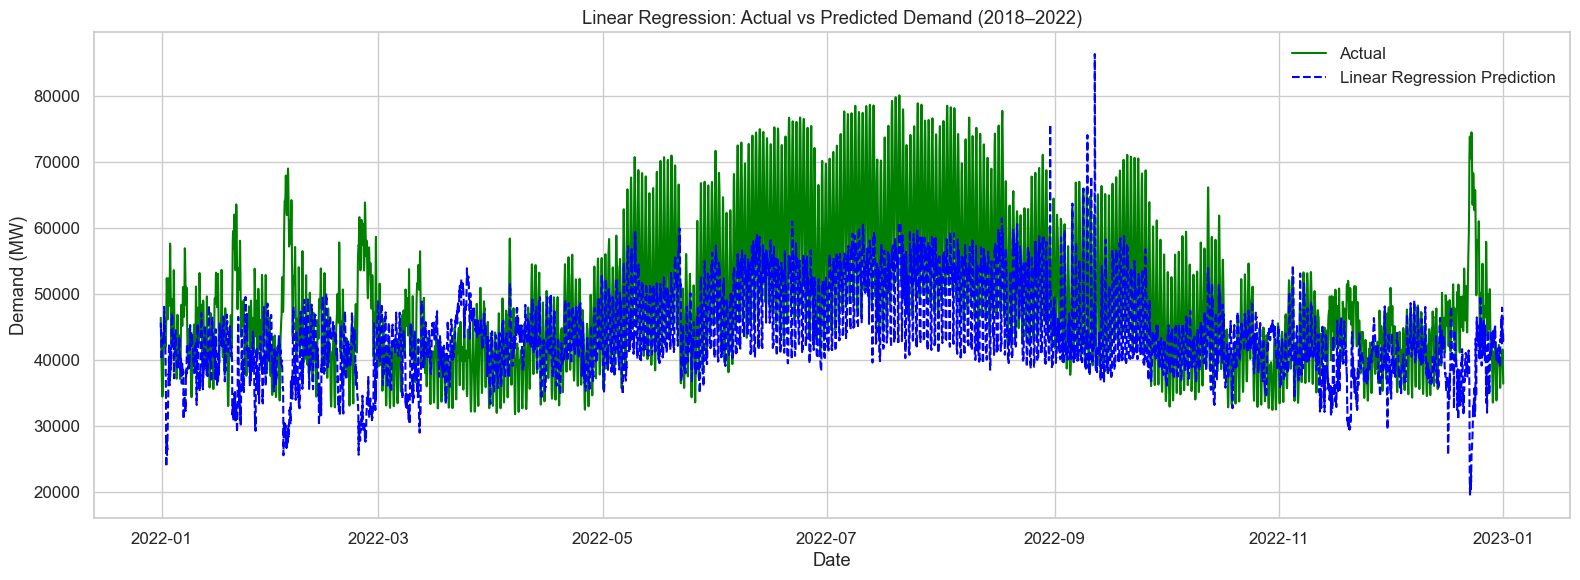

In [106]:
# Plot: Actual vs Predicted
test_dates = df['timestamp'][split_idx:]
plt.figure(figsize=(16, 6))
plt.plot(test_dates, y_test.values, label='Actual', color='green')
plt.plot(test_dates, y_pred_test, label='Linear Regression Prediction', color='blue', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted Demand (2018–2022)')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
# Save the model and scaler
joblib.dump(lr_model, 'var/models/linear_regression_model_ERCOT.joblib')
joblib.dump(scaler, 'var/models/linear_regression_scaler_ERCOT.joblib')

['var/models/linear_regression_scaler_ERCOT.joblib']

## Linear Regression Forecasting on 2023 Data

In [117]:
# Load 2023 data (must follow same structure as training data)
df_2023 = pd.read_csv('var/2023_all_data.csv', parse_dates=['timestamp'])

In [119]:
# Define features
features = [
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]

In [120]:
# Load saved model and scaler
lr_model = joblib.load('var/models/linear_regression_model_ERCOT.joblib')
scaler = joblib.load('var/models/linear_regression_scaler_ERCOT.joblib')

In [123]:
# Scale 2023 features
X_2023_scaled = scaler.transform(df_2023[features])

# Predict
predictions_2023 = lr_model.predict(X_2023_scaled)

# Create result DataFrame
linear_pred_df = pd.DataFrame({
    'timestamp': df_2023['timestamp'],
    'linear_regression_pred': predictions_2023
})


In [124]:
# Save to CSV
linear_pred_df.to_csv('var/predictions/linear_regression_predictions_2023_updated.csv', index=False)
print("✅ Linear Regression predictions for 2023 saved to CSV.")

✅ Linear Regression predictions for 2023 saved to CSV.


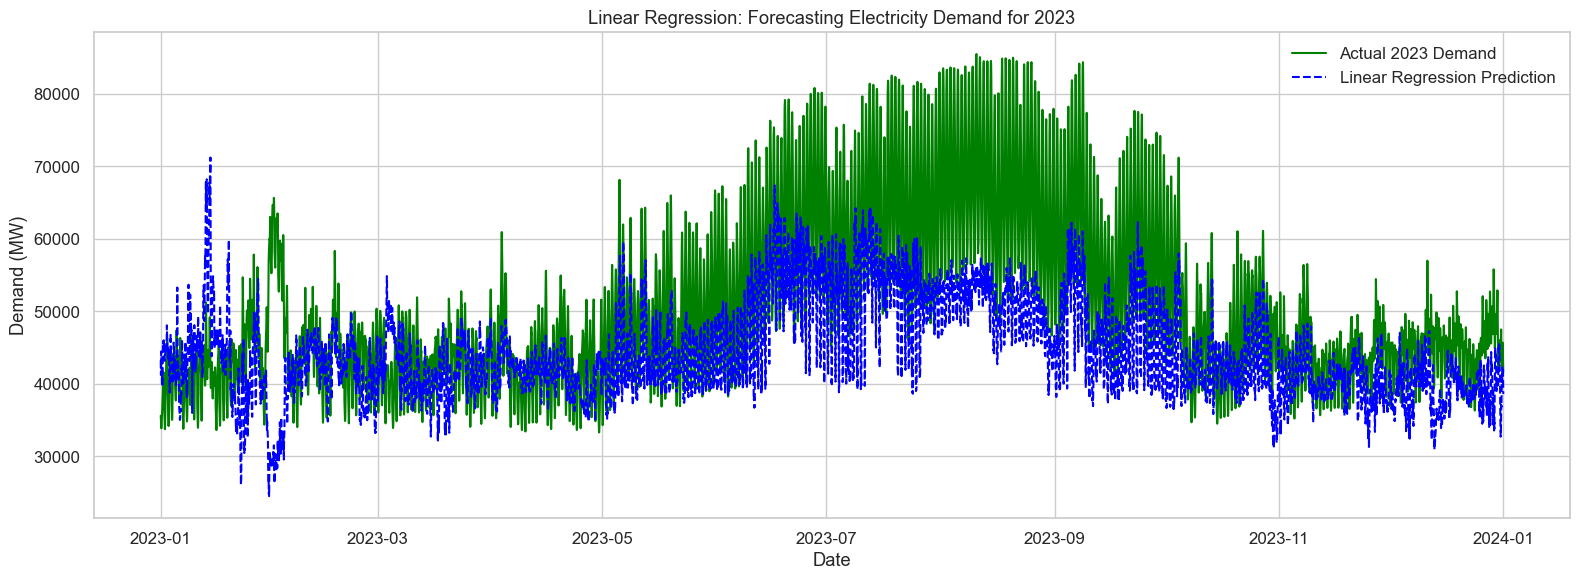

In [125]:
# Optional: Plot predictions vs actual
plt.figure(figsize=(16, 6))
plt.plot(df_2023['timestamp'], df_2023['ERCOT'], label='Actual 2023 Demand', color='green')
plt.plot(df_2023['timestamp'], predictions_2023, label='Linear Regression Prediction', linestyle='--', color='blue')
plt.title('Linear Regression: Forecasting Electricity Demand for 2023')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
# Actual and predicted values
y_true_2023 = df_2023['ERCOT'].values
y_pred_2023 = predictions_2023

In [132]:
# Evaluation function
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    accuracy = 100 - mape
    return mae, rmse, mape, accuracy

# Run evaluation
mae_2023, rmse_2023, mape_2023, acc_2023 = evaluate(y_true_2023, y_pred_2023)

# Print results
print("🔹 Linear Regression Forecasting (2023) Evaluation Metrics:")
print(f"MAE: {mae_2023:.2f}")
print(f"RMSE: {rmse_2023:.2f}")
print(f"MAPE: {mape_2023:.2f}%")
print(f"Final Accuracy: {acc_2023:.2f}%")


🔹 Linear Regression Forecasting (2023) Evaluation Metrics:
MAE: 7993.37
RMSE: 10868.74
MAPE: 14.32%
Final Accuracy: 85.68%


## Merge and Compare All Models

In [162]:
# Load prediction CSVs
df_lstm = pd.read_csv('ML_Data/2023_lstm_prediction.csv', parse_dates=['timestamp'])
df_transformer = pd.read_csv('ML_Data/2023_transformer_pred.csv', parse_dates=['timestamp'])
df_lr = pd.read_csv('ML_Data/linear_regression_predictions_2023_updated.csv', parse_dates=['timestamp'])

In [164]:
# Rename columns for clarity
df_lstm.rename(columns={'predicted_demand': 'lstm_pred'}, inplace=True)

In [166]:
# Merge all on timestamp
merged_df = df_lstm.merge(df_transformer, on='timestamp', how='inner')
merged_df = merged_df.merge(df_lr, on='timestamp', how='inner')

In [170]:
# Drop rows with missing values
merged_df.dropna(inplace=True)

In [172]:
merged_df.head()

,timestamp,lstm_pred,ERCOT,transformer_pred,linear_regression_pred
0,2023-01-01 01:00:00,35083.950304,35609.173887,34703.830753,43231.574553
1,2023-01-01 02:00:00,35617.214363,35012.298856,34530.598541,41220.267288
2,2023-01-01 03:00:00,35721.843124,34369.582295,34052.180130,41345.789245
3,2023-01-01 04:00:00,35149.047775,34000.730337,33399.715560,44472.861881
4,2023-01-01 05:00:00,35371.010962,33865.078669,33548.010235,42824.906094


In [174]:
# Define evaluation function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    accuracy = 100 - mape
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "Final Accuracy (%)": accuracy
    }


In [176]:
# Evaluate all models
metrics_lstm = evaluate_model(merged_df['ERCOT'], merged_df['lstm_pred'])
metrics_trans = evaluate_model(merged_df['ERCOT'], merged_df['transformer_pred'])
metrics_lr = evaluate_model(merged_df['ERCOT'], merged_df['linear_regression_pred'])

In [178]:
# Display results
print("\n🔹 LSTM:", metrics_lstm)
print("🔹 Transformer:", metrics_trans)
print("🔹 Linear Regression:", metrics_lr)


🔹 LSTM: {'MAE': 3559.4111269504715, 'RMSE': 4701.071057963052, 'MAPE (%)': 6.687934251930663, 'Final Accuracy (%)': 93.31206574806933}
🔹 Transformer: {'MAE': 843.7989652423929, 'RMSE': 1198.5626651404443, 'MAPE (%)': 1.6742064766368552, 'Final Accuracy (%)': 98.32579352336315}
🔹 Linear Regression: {'MAE': 7792.4695195373115, 'RMSE': 10633.364369864194, 'MAPE (%)': 14.002559193987075, 'Final Accuracy (%)': 85.99744080601292}


In [180]:
# Save merged comparison file (optional)
#merged_df.to_csv('var/predictions/final_all_3_model_predictions.csv', index=False)

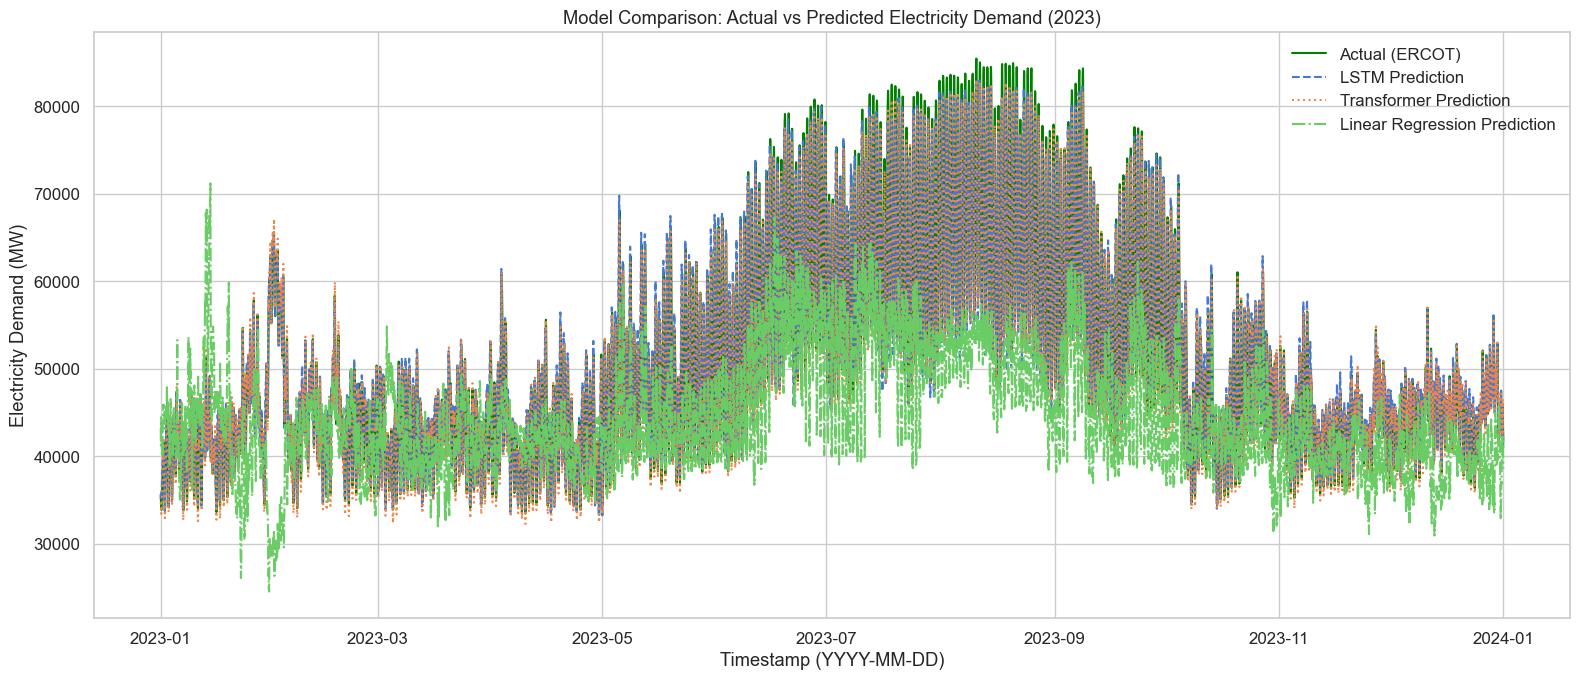

In [201]:
# Plot comparison
plt.figure(figsize=(16, 7))
plt.plot(merged_df['timestamp'], merged_df['ERCOT'], label='Actual (ERCOT)', color='green')
plt.plot(merged_df['timestamp'], merged_df['lstm_pred'], label='LSTM Prediction', linestyle='--')
plt.plot(merged_df['timestamp'], merged_df['transformer_pred'], label='Transformer Prediction', linestyle=':')
plt.plot(merged_df['timestamp'], merged_df['linear_regression_pred'], label='Linear Regression Prediction', linestyle='-.')
plt.title('Model Comparison: Actual vs Predicted Electricity Demand (2023)')
plt.xlabel('Timestamp (YYYY-MM-DD)')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the image
plt.savefig('plots/model_comparison_2023.png', dpi=300)
plt.show()


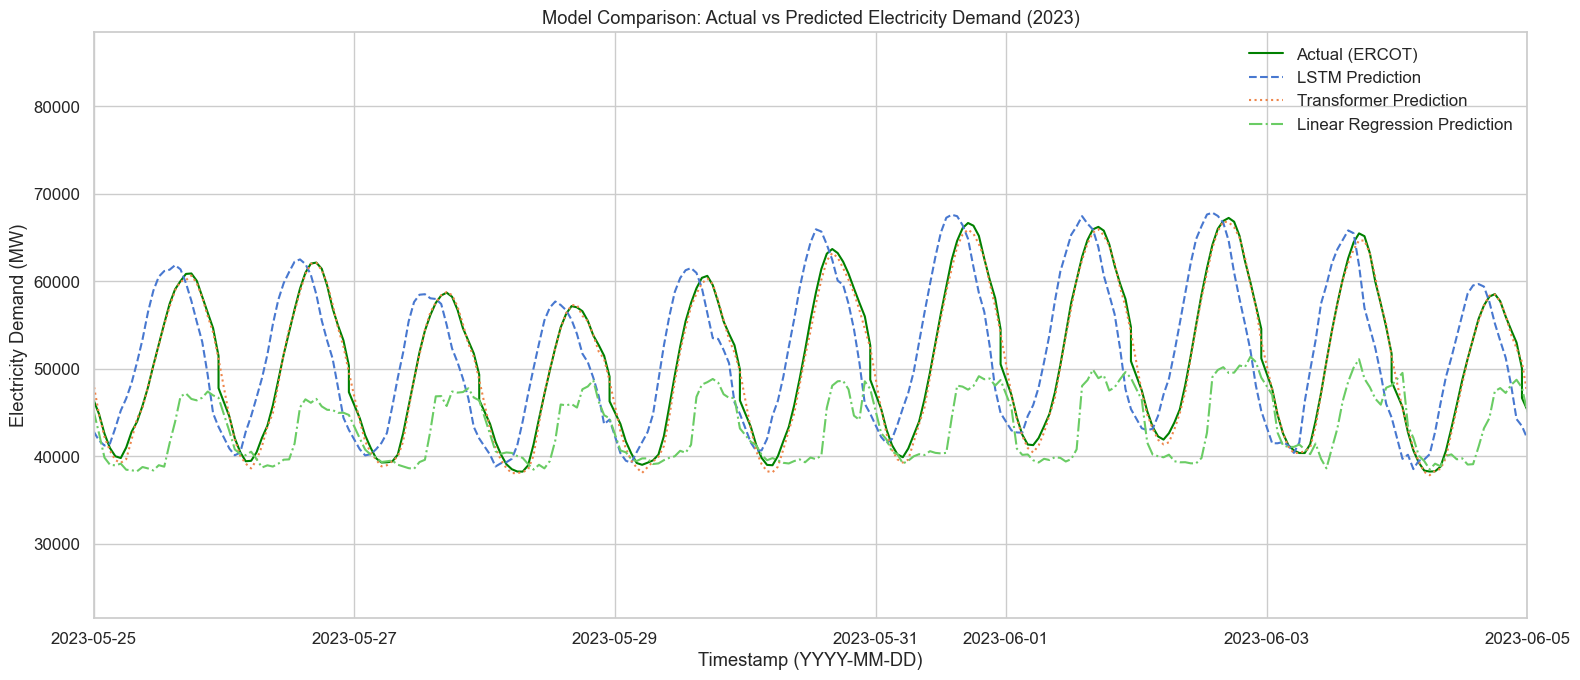

In [202]:
# Plot comparison
plt.figure(figsize=(16, 7))
plt.plot(merged_df['timestamp'], merged_df['ERCOT'], label='Actual (ERCOT)', color='green')
plt.plot(merged_df['timestamp'], merged_df['lstm_pred'], label='LSTM Prediction', linestyle='--')
plt.plot(merged_df['timestamp'], merged_df['transformer_pred'], label='Transformer Prediction', linestyle=':')
plt.plot(merged_df['timestamp'], merged_df['linear_regression_pred'], label='Linear Regression Prediction', linestyle='-.')
plt.title('Model Comparison: Actual vs Predicted Electricity Demand (2023)')
plt.xlabel('Timestamp (YYYY-MM-DD)')
plt.ylabel('Electricity Demand (MW)')
plt.xlim(datetime.datetime(2023,5,25), datetime.datetime(2023,6,5))
plt.legend()
plt.grid(True)
plt.tight_layout()
# Save the image
plt.savefig('plots/model_comparison_2023_sample_data.png', dpi=300)
plt.show()